In [ ]:
!pip install keras

# Importing the dataset

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:21<00:00, 226MB/s]
100% 2.29G/2.29G [00:22<00:00, 112MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

# CLAHE implementation

In [ ]:
import os
import cv2

def apply_clahe_to_folder(input_folder, output_folder, clip_limit=2.0, grid_size=(8, 8)):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through subfolders (classes)
    for class_folder in os.listdir(input_folder):
        class_folder_path = os.path.join(input_folder, class_folder)
        output_class_folder_path = os.path.join(output_folder, class_folder)

        # Create output class folder if it doesn't exist
        if not os.path.exists(output_class_folder_path):
            os.makedirs(output_class_folder_path)

        # Iterate through images in the class folder
        for filename in os.listdir(class_folder_path):
            input_image_path = os.path.join(class_folder_path, filename)
            output_image_path = os.path.join(output_class_folder_path, filename)

            # Read the image
            image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)

            # Apply CLAHE
            clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
            clahe_image = clahe.apply(image)

            # Save the processed image
            cv2.imwrite(output_image_path, clahe_image)

if __name__ == "__main__":

    # Set CLAHE parameters
    clip_limit = 2.0
    grid_size = (8, 8)

    # Apply CLAHE to the dataset
    apply_clahe_to_folder('/content/chest_xray/train', '/content/chest_xray/train_clahe', clip_limit, grid_size)
    apply_clahe_to_folder('/content/chest_xray/test', '/content/chest_xray/test_clahe', clip_limit, grid_size)
    apply_clahe_to_folder('/content/chest_xray/val', '/content/chest_xray/val_clahe', clip_limit, grid_size)

In [ ]:
train_dir = '/content/chest_xray/train_clahe'
val_dir = '/content/chest_xray/val_clahe'
test_dir = '/content/chest_xray/test_clahe'

# Importing important libraries

In [ ]:
from keras.layers import Concatenate
from keras.layers import Input
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D, Flatten,Conv2D, Dense,BatchNormalization,GlobalAveragePooling2D,Dropout
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping

#Creating Data Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range = 2.0)
test_datagen = ImageDataGenerator(rescale = 1. / 255)
val_datagen = ImageDataGenerator(rescale = 1. / 255)

img_width , img_height = [224,224]
batch_size = 16

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


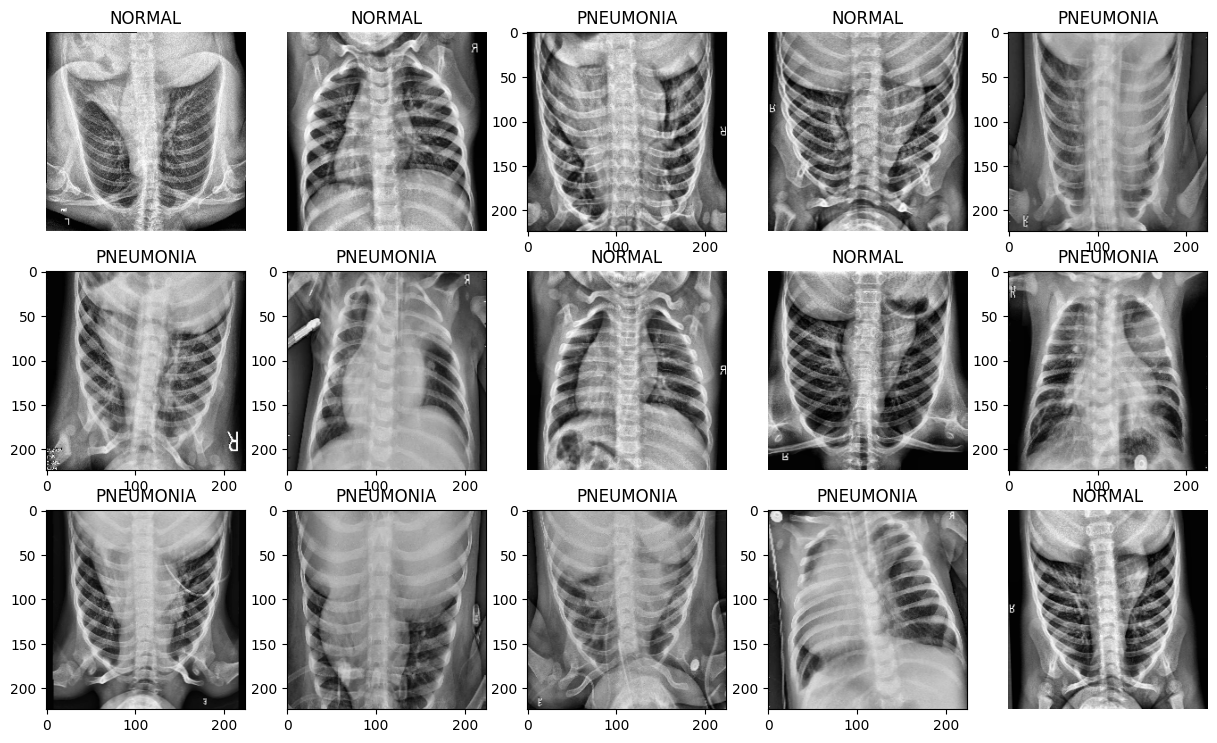

In [ ]:
image_batch, label_batch = next(iter(train_generator))

def show_batch(image_batch, label_batch):
      plt.figure(figsize=(15, 15))
      for n in range(15):
          ax = plt.subplot(5, 5, n + 1)
          plt.imshow(image_batch[n])
          if label_batch[n]:
              plt.title('PNEUMONIA')
          else:
              plt.title('NORMAL')
              plt.axis('off')

show_batch(image_batch, label_batch)

# Model Creation

In [ ]:
input_shape = (224,224,3)
input_layer = Input(shape = (224, 224, 3))
#first model
mobilenet_base = MobileNetV2(weights = 'imagenet',input_shape = input_shape,include_top = False)

densenet_base = DenseNet169(weights = 'imagenet', input_shape = input_shape,include_top = False)

for layer in mobilenet_base.layers:
    layer.trainable =  False
for layer in densenet_base.layers:
    layer.trainable = False

model_mobilenet = mobilenet_base(input_layer)
model_mobilenet = GlobalAveragePooling2D()(model_mobilenet)
output_mobilenet = Flatten()(model_mobilenet)
model_densenet = densenet_base(input_layer)
model_densenet = GlobalAveragePooling2D()(model_densenet)
output_densenet = Flatten()(model_densenet)

merged = Concatenate()([output_mobilenet, output_densenet])

x = BatchNormalization()(merged)
x = Dense(256,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(64,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(1, activation = 'sigmoid')(x)
stacked_model = Model(inputs = input_layer, outputs = x)

In [ ]:
optm = Adam(learning_rate=0.001)
stacked_model.compile(loss='binary_crossentropy', optimizer=optm, metrics=['accuracy'])

In [ ]:
stacked_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['input_7[0][0]']             
 tional)                                                                                          
                                                                                                  
 densenet169 (Functional)    (None, 7, 7, 1664)           1264288   ['input_7[0][0]']             
                                                          0                                       
                                                                                            

In [ ]:
model_save = ModelCheckpoint('./stacked_model.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss',
                             mode = 'min', verbose = 1)

In [ ]:
cw = {0:6,1:0.5}
stacked_history = stacked_model.fit(train_generator, epochs = 20, validation_data = test_generator, callbacks=[model_save],class_weight = cw)

Epoch 1/20
326/326 [==============================] - ETA: 0s - loss: 0.5707 - accuracy: 0.7115
Epoch 1: val_loss did not improve from 0.23722
326/326 [==============================] - 141s 389ms/step - loss: 0.5707 - accuracy: 0.7115 - val_loss: 0.4689 - val_accuracy: 0.8029
Epoch 2/20
326/326 [==============================] - ETA: 0s - loss: 0.3419 - accuracy: 0.8171
Epoch 2: val_loss did not improve from 0.23722
326/326 [==============================] - 124s 380ms/step - loss: 0.3419 - accuracy: 0.8171 - val_loss: 0.2927 - val_accuracy: 0.8974
Epoch 3/20
326/326 [==============================] - ETA: 0s - loss: 0.3057 - accuracy: 0.8543
Epoch 3: val_loss did not improve from 0.23722
326/326 [==============================] - 122s 373ms/step - loss: 0.3057 - accuracy: 0.8543 - val_loss: 0.2784 - val_accuracy: 0.8862
Epoch 4/20
326/326 [==============================] - ETA: 0s - loss: 0.2549 - accuracy: 0.8779
Epoch 4: val_loss improved from 0.23722 to 0.23350, saving model to ./

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


326/326 [==============================] - 124s 380ms/step - loss: 0.2549 - accuracy: 0.8779 - val_loss: 0.2335 - val_accuracy: 0.9103
Epoch 5/20
326/326 [==============================] - ETA: 0s - loss: 0.2552 - accuracy: 0.8806
Epoch 5: val_loss did not improve from 0.23350
326/326 [==============================] - 136s 416ms/step - loss: 0.2552 - accuracy: 0.8806 - val_loss: 0.2495 - val_accuracy: 0.9022
Epoch 6/20
326/326 [==============================] - ETA: 0s - loss: 0.2549 - accuracy: 0.8886
Epoch 6: val_loss did not improve from 0.23350
326/326 [==============================] - 123s 376ms/step - loss: 0.2549 - accuracy: 0.8886 - val_loss: 0.2813 - val_accuracy: 0.8846
Epoch 7/20
326/326 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.8723
Epoch 7: val_loss did not improve from 0.23350
326/326 [==============================] - 127s 390ms/step - loss: 0.2466 - accuracy: 0.8723 - val_loss: 0.3079 - val_accuracy: 0.8894
Epoch 8/20
326/326 [===========

In [ ]:
stacked_model.save('final.h5')

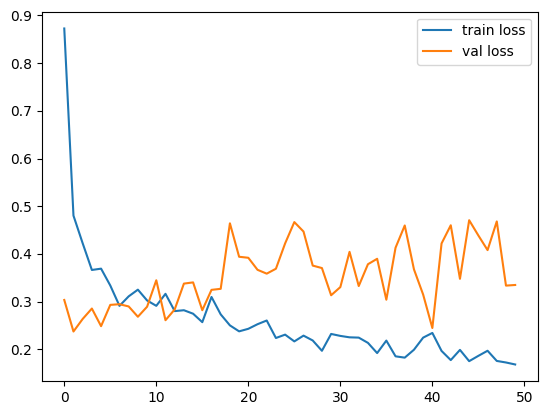

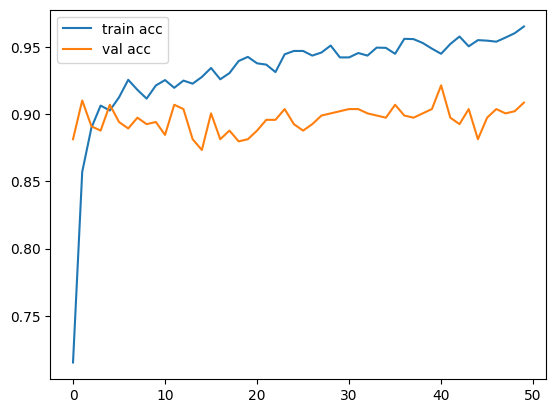

In [ ]:
plt.plot(stacked_history.history["loss"], label = "train loss")
plt.plot(stacked_history.history["val_loss"], label = "val loss")
plt.legend()
plt.show();
plt.savefig("LossVal_loss")

# Plotting the accuracy
plt.plot(stacked_history.history["accuracy"], label = "train acc")
plt.plot(stacked_history.history["val_accuracy"], label = "val acc")
plt.legend()
plt.show()

#Testing of model

In [ ]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 868.3 kB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import load_model
from keras_preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

In [ ]:
scores = stacked_model.evaluate(test_generator)

39/39 [==============================] - 12s 307ms/step - loss: 0.3348 - accuracy: 0.9087


In [ ]:
scores

[0.33481237292289734, 0.9086538553237915]

In [ ]:
img = image.load_img("/content/chest_xray/test_clahe/NORMAL/IM-0001-0001.jpeg", target_size = (224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
img_data = preprocess_input(x)
print(stacked_model.predict(x)[0][0])

1/1 [==============================] - 0s 44ms/step
1.0


In [ ]:
img_path = '/content/chest_xray/test_clahe/PNEUMONIA/person101_bacteria_485.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize

In [ ]:
# Make prediction
prediction = stacked_model.predict(img_array)

# Print the prediction
print(prediction)

1/1 [==============================] - 0s 44ms/step
[[0.995867]]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
predictions = stacked_model.predict(test_generator)

# Convert predicted probabilities to class labels
predicted_labels = (predictions > 0.5).astype(int)

# Get true labels from the generator
true_labels = test_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate and print classification report
report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices)
print("\nClassification Report:")
print(report)

1/1 [==============================] - 0s 469ms/step
Confusion Matrix:
[[4 4]
 [5 3]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.44      0.50      0.47         8
   PNEUMONIA       0.43      0.38      0.40         8

    accuracy                           0.44        16
   macro avg       0.44      0.44      0.44        16
weighted avg       0.44      0.44      0.44        16

